In [ ]:
# default_exp oco2map

In [ ]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# If the graph do not display, try :
#!jupyter labextension install jupyterlab-plotly
# You may have to upgrade Node and Jupyter

# MAP : Module to display the data on a map

In [ ]:
# export
import plotly.graph_objects as go

## Display a 2D scatter plot of the mesured CO2 level together with the evaluation method

In [ ]:
# export
def build_sounding_scatter(df_sounding, gaussian_param, with_dash = False):
    sounding_plot = {
            'data': [
                go.Scatter(
                    x=df_sounding['distance'],
                    y=df_sounding['xco2'],
                    text='xco2',
                    mode='markers',
                    opacity=0.5,
                    marker={
                        'size': 5,
                        'line': {'width': 0.5, 'color': 'white'}
                    },
                    name="xco2"
                ),
                go.Scatter(x=df_sounding['distance'], y=df_sounding['gaussian_y'], name="Gaussian fit",
                    hoverinfo='name',
                    line_shape='spline')
            ],
            'layout': go.Layout(
                xaxis={'title': 'Distance (km)'},
                yaxis={'title': 'CO² level in ppm'},
                #margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
                legend={'x': 0, 'y': 1},
                hovermode='closest'
            )
        }
    return sounding_plot

In [ ]:
from oco2peak.datasets import Datasets
from oco2peak import find_peak
import re
import plotly.io as pio
import json

config_file = './configs/config.json'
# Load config
with open(config_file) as json_data_file:
    config = json.load(json_data_file)
datasets = Datasets(config_file)
url_month = datasets.get_files_urls('result_for_oco2_1808')[0]
url_peak = datasets.get_files_urls('peak_data-si_2018082505')[0]
print(url_peak)
df_month = datasets.get_dataframe(url_month)
#df_month.head(3)
df_peak = datasets.get_dataframe(url_peak)

https://storage.gra.cloud.ovh.net/v1/AUTH_2aaacef8e88a4ca897bb93b984bd04dd/oco2//datasets/oco-2/peaks-detected-details/peak_data-si_2018082505142073.json


2018082505142073


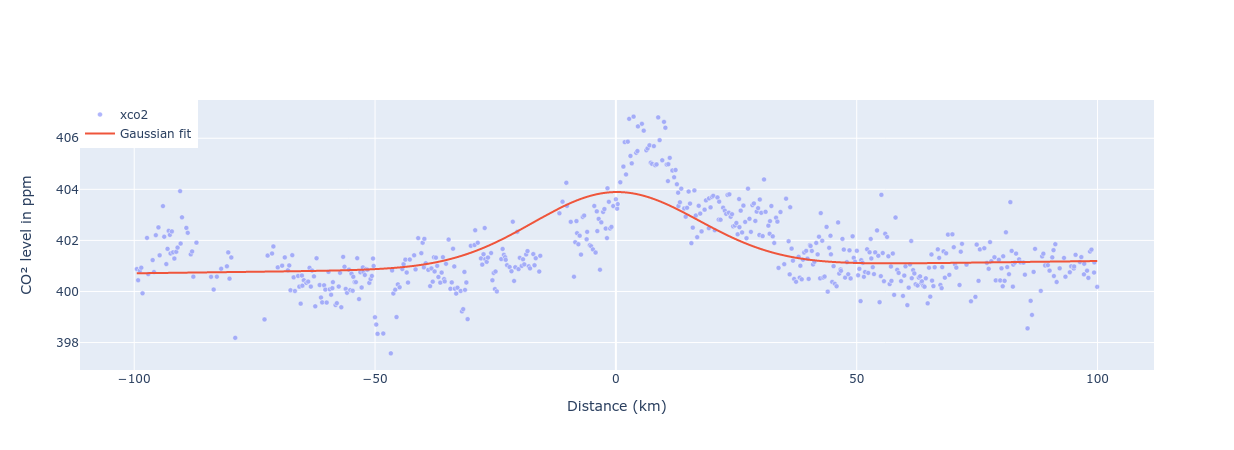

In [ ]:

sounding_id = re.findall(r'(\d{16})', url_peak)[-1]
print(sounding_id)
gaussian_param = datasets.get_gaussian_param(sounding_id, df_month)
df_peak['gaussian_y'] = df_peak.distance.apply(
    lambda x: find_peak.gaussian(x=x, m=gaussian_param['slope'], b=gaussian_param['intercept'], A=gaussian_param['amplitude'], sig=gaussian_param['sigma']))

sounding_scatter = build_sounding_scatter(df_peak, gaussian_param, with_dash = False)
pio.show(sounding_scatter)

## Display the CO2 measurement on a map

In [ ]:
# export
def build_sounding_map(df_sounding, mapbox_token):
    df = df_sounding
    center_lat = df.latitude.min() + (df.latitude.max() - df.latitude.min())/2
    center_lon = df.longitude.min() + (df.longitude.max() - df.longitude.min())/2
    xco_sounding_mapbox = go.Figure(go.Scattermapbox(
        lat=df.latitude,
        lon=df.longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            color = df['xco2'], size=5
        ),
        
        text=df.xco2,
    ))
    xco_sounding_mapbox.update_layout(
        mapbox_style="satellite-streets",
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_token,
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=center_lat,
                lon=center_lon
            ),
            pitch=0,
            zoom=6
        )
    )
    return xco_sounding_mapbox

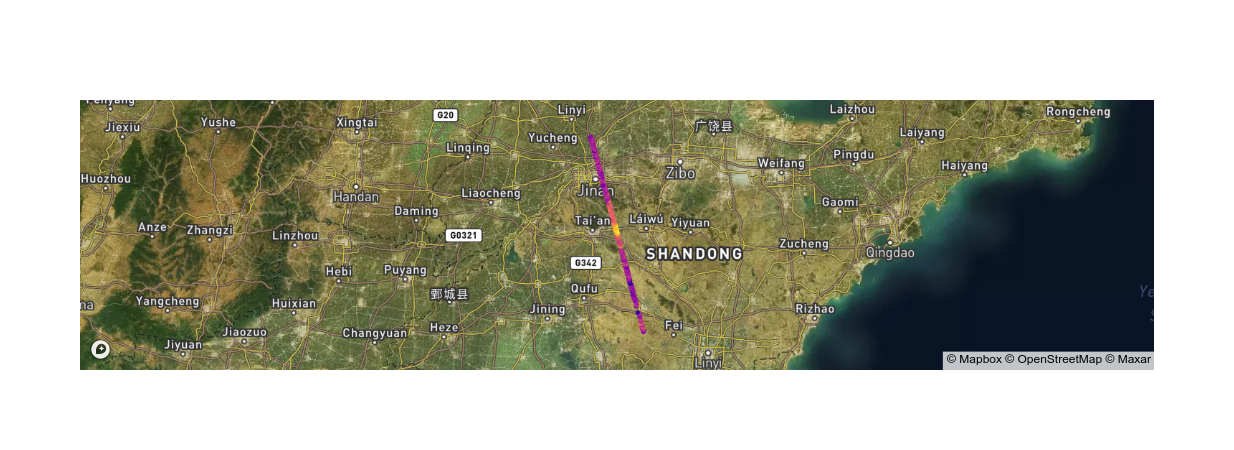

In [ ]:
mapbox_token = config['mapbox_token']
sounding_scatter = build_sounding_map(df_peak, mapbox_token)
pio.show(sounding_scatter)

## Display all the detected peak on a map

In [ ]:
# export
import folium
def build_world_map(data):
    folium_map = folium.Map([43, 0], zoom_start=4)
    folium.TileLayer("CartoDB dark_matter", name="Dark mode").add_to(folium_map)

    # Adding detected peaks
    peaks_group = folium.FeatureGroup(name="Peaks").add_to(folium_map)
    peaks_group_circle = folium.FeatureGroup(name=" - 50km Circles").add_to(folium_map)
    peaks_group_wind = folium.FeatureGroup(name=" - Wind Vectors").add_to(folium_map)
    
    for _, row in data.iterrows():
        radius = row["amplitude"]/20
        color="#FF3333" # red
        tooltip =  "GPS : ["+str(round(row['latitude'],2))+" ; "+str(round(row['longitude'],2))+"]"
        sounding = str(row['sounding_id'])
        date = str(row['sounding_id'])
        orbit = str(row['orbit'])
        wind = [[row['latitude'],row['longitude']],[row['latitude']+row['windspeed_u'],row['longitude']+row['windspeed_v']]]
        
        popup_html="""<h4>"""+tooltip+"""</h4>"""+date+"""<p>sounding_id: """+sounding+"""</br>orbit: """+orbit+"""</p>"""
        popup_html+='<p><input type="button" value="Show plot"'
        # Injecting JavaScript in popup to fire the Dash Callback
        popup_html+='onclick="\
            let bco_input = parent.document.getElementById(\'input_sounding\'); \
            let lastValue = bco_input.value;'
        popup_html+=f'bco_input.value = \'{sounding}\';'
        popup_html+="let bco_event = new Event('input', { bubbles: true });\
            bco_event.simulated = true;\
            let tracker = bco_input._valueTracker;\
            if (tracker) {\
            tracker.setValue(lastValue);\
            }\
            bco_input.dispatchEvent(bco_event);\
            elt.dispatchEvent(new Event('change'));\
            \"/></p>"
        #onclick="plot_data(\'{url}\', {slope}, {intercept}, {amplitude}, {sigma});"/></p>'

        popup=folium.Popup(popup_html, max_width=450)
        
        peaks_group.add_child(folium.CircleMarker(location=(row["latitude"],
                                    row["longitude"]),
                            radius=radius,
                            color=color,
                            tooltip=tooltip,
                            popup=popup,
                            fill=True))

        peaks_group_circle.add_child(folium.Circle(location=(row["latitude"],
                            row["longitude"]),
                            radius=50000,
                            color='#949494',
                            weight = 1,
                            fill=False))
        
        peaks_group_wind.add_child(folium.PolyLine(wind,
                        color='#B2B2B2',
                        weight = 1))
    return folium_map


In [ ]:
folium_map = build_world_map(df_month)
folium_map

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted WIP_OCO2_Capture.ipynb.
Converted datasets.ipynb.
Converted find_peak.ipynb.
Converted index.ipynb.
Converted map.ipynb.
